# Validation Document

The validation of the physics of the pipeline is done on the validation document. The main document is an R notebook file: y3_cluster_cpp/validations/physics_validation.Rmd.

## Benchmarks
Here we generate the the following benchmark quantities using `pyccl` and `cluster-toolkit`:
- $\Delta \Sigma_{NFW}$ profile
- $P_{2h}$ without bias


## Setup Values

In [1]:
# cosmological parameters
# Plack Cosmology
h0 = 0.6726       # H0 (km/s/Mpc)/100.0km/s/Mpc 
omega_m = 0.3141  # density fraction for matter today
omega_b = 0.04    # density fraction for baryons today
omega_k = 0.0     # spatial curvature
mmnu = 0.06       # 


In [2]:
# Redshift fixed values
zlens = 0.35
zsource = 0.6

# NFW Concentration is CONSTANT
ci = 5

In [3]:
# set vectors
rmin = 0.1
rmax = 10.0
rsize = 100

# in log(Mass)
mmin = 13.5 
mmax = 15.0
msize = 20

zmin = 0.1
zmax = 0.6
zsize = 20

eTimes = dict()

In [4]:
import numpy as np
rvec = np.logspace(np.log10(rmin), np.log10(rmax), rsize)
mvec = np.logspace(mmin, mmax, msize)
zvec = np.linspace(zmin, zmax, zsize)

## Start Packages

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from time import time

In [6]:
import seaborn as sns
sns.set_context('talk')

## $\Delta \Sigma_{NFW}$ profile: CCL

You can find here a very nice series of CCL tutorials
https://github.com/LSSTDESC/CCLX/blob/master/Halo%20profiles.ipynb

In [7]:
import pyccl as ccl
cosmoc = ccl.Cosmology(Omega_c=omega_m-omega_b, Omega_b=omega_b, h=h0, sigma8=0.83, n_s=0.96)

# We will also use a mass definition with Delta = 200, and the Duffy 2008 concentration-mass relation
hmd_200c = ccl.halos.MassDef200c()

# we set the concetration to be constant
# https://github.com/LSSTDESC/CCL/blob/master/pyccl/halos/concentration.py#L548
conc = ccl.halos.ConcentrationConstant(ci,mdef=hmd_200c)

In [8]:
def computeDsigma(self, r_arr, mass, z_lens, z_source, mdef=hmd_200c):
    a_lens = 1/(1+z_lens)
    a_source = 1/(1+z_source)
    
    Sigma = self.projected(cosmoc, r_arr, mass, a_lens, mdef)
    Sigma_bar = self.cumul2d(cosmoc, r_arr, mass, a_lens, mdef)
    return Sigma_bar - Sigma

In [9]:
t0 = time()
dSigma = np.zeros((msize, rsize))

for i in range(msize):
    nfw = ccl.halos.HaloProfileNFW(conc, truncated=False)
    dSigma[i] = computeDsigma(nfw, rvec, mvec[i], zlens, zsource)
eTimes['CCL'] = (time()-t0)
print('It takes %.3f sec'%(eTimes['CCL']))


It takes 0.148 sec


Text(0.5, 1.0, 'Planck Cosmology; c = 5, z = 0.35')

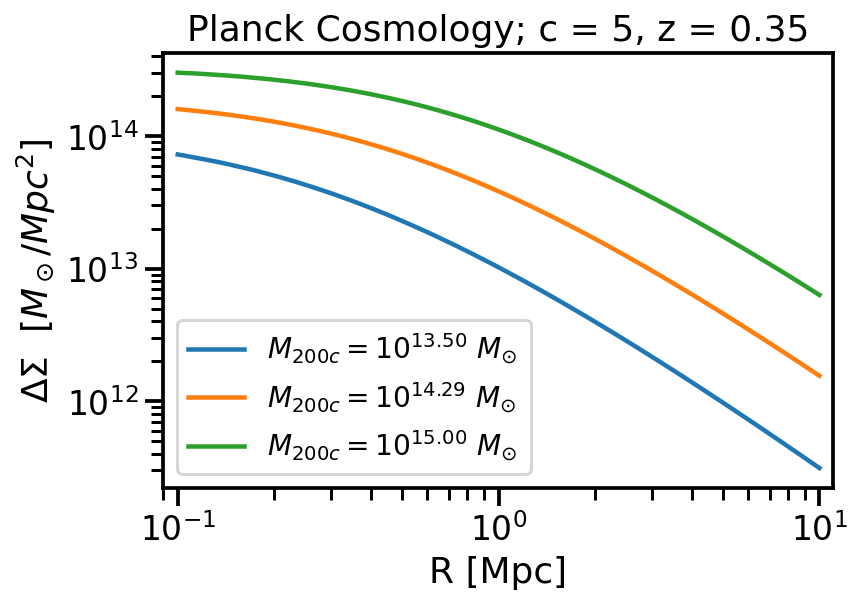

In [10]:
plt.loglog()
for ix in [0,int(msize/2),msize-1]:
    plt.plot(rvec, dSigma[ix], label='$M_{200c}=10^{%.2f} \, \, M_{\odot}$ '%(np.log10(mvec[ix])))
plt.xlim(0.09,11.)
plt.legend(fontsize=14)
plt.xlabel('R [Mpc]')
plt.ylabel(r'$\Delta \Sigma$  [$M_\odot/Mpc^2$]')
plt.title('Planck Cosmology; c = %i, z = %.2f'%(ci, zlens))

In [11]:
# outfile = 'test_dsgima_ccl_z%s.npz'%(str(zlens).replace('.','p'))
# np.savez(outfile, m=mvec, r=rvec, dSigma=dSigma)
# print('Saved Outfile: ',outfile)

## $P_{2h}$ without bias

For the second-halo term we use `cluster-toolkit`, see the [documentation](https://cluster-toolkit.readthedocs.io/en/latest/source/projected_density_profiles.html).
Unfortunately, I couldn't find an option on `ccl` to create a $\gamma_T$ profile out a of given power spectrum.


### Power Spectrum From Camb

In [12]:
#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /global/homes/j/jesteves/.conda/envs/clevarenv/lib/python3.9/site-packages/camb


In [13]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
h2 = h0**2
ombh2 = omega_b*h2
omch2 = omega_m*h2 - ombh2

pars = camb.CAMBparams()
pars.set_cosmology(H0=100*h0, ombh2=ombh2, omch2=omch2)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=list(zvec), kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh_lin, z_lin, pk_lin = results.get_matter_power_spectrum(minkh=3e-5, maxkh=1000, npoints = 1000)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=3e-5, maxkh=1000, npoints = 1000)

Note: redshifts have been re-sorted (earliest first)


### Compute $\Delta \Sigma$ from Pk

In [27]:
rvec2 = np.append(rvec,[rmax+0.1])

In [28]:
from cluster_toolkit import deltasigma, xi

dummyM = 3.2e+14
dummyC = 5.

Xi_2 = np.zeros((zsize, rsize))
Sigma_2 = np.zeros((zsize, rsize))
dSigma_2 = np.zeros((zsize, rsize))
# rvec2 = np.append(rvec,[rmax+0.1])

for i in range(zsize):
    xi_mm  = xi.xi_mm_at_r(rvec2, kh_nonlin, pk_nonlin[i])
    
    args = rvec/h0, rvec2/h0, xi_mm, dummyM, dummyC, omega_m
    sigma2 = deltasigma.Sigma_at_R(*args)
    
    args = rvec/h0, rvec/h0, sigma2, dummyM, dummyC, omega_m
    dsigma2 = deltasigma.DeltaSigma_at_R(*args)
    
    Xi_2[i]    = np.interp(rvec,rvec2,xi_mm)
    Sigma_2[i] = sigma2
    dSigma_2[i] = dsigma2
    

Text(0.5, 1.0, 'Planck Cosmology; c = 5, z = 0.35')

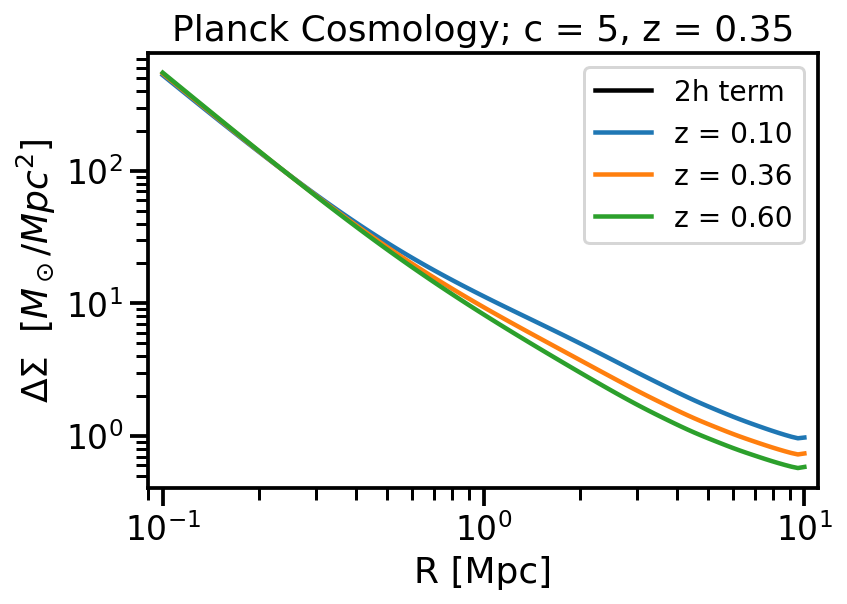

In [33]:
plt.loglog()
plt.plot([0.0],[10],color='k',label='2h term')
for ix in [0,int(zsize/2),zsize-1]:
    plt.plot(rvec, dSigma_2[ix], label='z = %.2f'%(zvec[ix]))

plt.xlim(0.09,11.)
plt.legend(fontsize=14)
plt.xlabel('R [Mpc]')
plt.ylabel(r'$\Delta \Sigma$  [$M_\odot/Mpc^2$]')
plt.title('Planck Cosmology; c = %i, z = %.2f'%(ci, zlens))

In [34]:
outfile = 'test_dsgima_ccl_z%s.npz'%(str(zlens).replace('.','p'))
np.savez(outfile, r=rvec, m=mvec, z=zvec, dSigma=dSigma, dSigma2=dSigma_2)
print('Saved outfile: ',outfile)

Saved outfile:  test_dsgima_ccl_z0p35.npz
